In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221104_btc_one_h12'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2021-07-07 11:00:00+00:00,ADAUSDT,1.4206,1.4330,1.4170,1.4300,14548171.0,2.077201e+07,43515.0,7770863.0,...,1.427578,1.428275,0.003467,0.001119,1.428347,1.426760,0.000923,-0.000663,0.001112,1.626014e-06
1,2021-06-20 11:00:00+00:00,ADAUSDT,1.3476,1.3533,1.3260,1.3293,38181143.0,5.110403e+07,87818.0,18535250.0,...,1.338757,1.337625,0.006228,0.003071,1.341067,1.336997,0.001983,-0.002087,0.003039,1.080156e-05
2,2021-06-19 23:00:00+00:00,ADAUSDT,1.3910,1.4018,1.3821,1.3829,15747336.0,2.191540e+07,54828.0,7464234.0,...,1.391135,1.391458,0.004761,0.001728,1.392305,1.390117,0.001062,-0.001127,0.001573,3.268865e-06
3,2021-06-25 09:00:00+00:00,ADAUSDT,1.3398,1.3570,1.3230,1.3289,37778606.0,5.060536e+07,79282.0,19752438.0,...,1.340072,1.341042,0.009537,0.002410,1.342172,1.338507,0.001910,-0.001755,0.002736,8.700572e-06
4,2021-06-11 12:00:00+00:00,ADAUSDT,1.5176,1.5199,1.5039,1.5108,16425309.0,2.482271e+07,61590.0,7741869.0,...,1.511205,1.511150,0.002715,0.001816,1.512712,1.510028,0.001377,-0.001307,0.001776,3.441971e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216692,2022-11-20 13:00:00+00:00,MATICUSDT,0.8319,0.8406,0.8309,0.8389,22440348.0,1.875767e+07,31310.0,11222641.0,...,0.835862,0.836175,0.002296,0.000776,0.836410,0.835240,0.000673,-0.000497,0.001400,2.420907e-06
216693,2022-11-06 17:00:00+00:00,MATICUSDT,1.1733,1.1831,1.1670,1.1711,31568644.0,3.705373e+07,56089.0,15193018.0,...,1.173257,1.173108,0.003391,0.001698,1.174662,1.172043,0.001387,-0.001232,0.002231,5.748859e-06
216694,2022-11-01 02:00:00+00:00,MATICUSDT,0.9042,0.9088,0.9015,0.9070,8149893.0,7.383741e+06,12876.0,4960282.0,...,0.905358,0.905417,0.001811,0.000511,0.905740,0.904975,0.000437,-0.000328,0.000845,8.586230e-07
216695,2022-11-20 06:00:00+00:00,MATICUSDT,0.8723,0.8740,0.8701,0.8731,6048424.0,5.272519e+06,10288.0,3272623.0,...,0.871785,0.871675,0.000802,0.000397,0.872032,0.871510,0.000268,-0.000253,0.000598,4.397236e-07


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-23 03:00:00+00:00 DOT        5.35300     5.41200     5.3450   
                          ETH     1162.82000  1170.00000  1157.7800   
                          LINK       6.49600     6.55100     6.4510   
                          MATIC      0.86320     0.86710     0.8565   
                          XRP        0.37550     0.37790     0.3742   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-23 03:00:00+00:00 DOT        5.3980  1.589311e+06     5.371000   
                          ETH     1170.0000  2.888221e+05  1162.535833   
                          LINK       6.5300  2.862410e+06     6.495667   
                          MATIC      0.8669  2.904710e+07     0.861817   
                          XRP        0.3776  4.409495e+07     0.376075   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-23 03:00:00+00:00 DOT        False  
                          ETH        False  
                          LINK       False  
                          MATIC      False  
                          XRP        False  

[363840 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    # for t_center in [2, 4, 6, 12, 24]:
    for t_center in [4, 6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)
        
        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])
            
        mem = get_joblib_memory()
        self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')

        
def nfr_calc_features(model, remove_count, X):
    model = clone(model)
    model.fit(X, np.arange(X.shape[0]))
    importances = model.feature_importances_

    features = list(range(X.shape[1]))
    feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
    feature_imp = feature_imp.sort_values('value')

    for i in range(X.shape[1] - remove_count, X.shape[1]):
        features.remove(int(feature_imp['feature'].iloc[i]))

    return np.array(features)

In [5]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor, StackingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        self._model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            # colsample_bytree=0.9,
            colsample_bytree=0.03,
            subsample=0.5,
            subsample_freq=1,
            # lambda_l2=1e1,
            random_state=1,
            n_jobs=-1,
        )
        
        lgbm2 = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            # colsample_bytree=0.9,
            colsample_bytree=0.03,
            subsample=0.5,
            subsample_freq=1,
            # lambda_l2=1e1,
            random_state=2,
            n_jobs=-1,
        )
        
        lgbm3 = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            # extra_trees=True,
            # colsample_bytree=0.9,
            # colsample_bytree=0.1,
            subsample=0.5,
            subsample_freq=1,
            lambda_l2=1e2,
            random_state=3,
            n_jobs=-1,
        )
        
        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        self._model = BaggingRegressor(self._model, random_state=1)
        # self._model = VotingRegressor([
        #     ('lgbm1', self._model),
        #     # ('lgbm2', lgbm2),
        #     # ('lgbm1', BaggingRegressor(self._model, n_estimators=1, random_state=1)),
        #     # ('lgbm2', BaggingRegressor(lgbm2, n_estimators=1, random_state=2)),
        #     # ('lgbm3', BaggingRegressor(lgbm3, n_estimators=1, random_state=3)),
        #     # ('lgbm3', lgbm3),
        # ])
        
        # self._model = RidgeCV(cv=5)
        
        # self._model = StackingRegressor(
        #     [
        #         ('lgbm1', self._model),
        #         ('lgbm3', lgbm3),
        #         ('ridge', RidgeCV(cv=5)),
        #     ], 
        #     final_estimator=RidgeCV(cv=5),
        #     cv=5,
        # )
        
        self._model = Pipeline([
            ('remove_nonstationary1', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
            )),
            ('remove_nonstationary2', NonstationaryFeatureRemover(
                estimator=nonstationary_est,
                remove_ratio=0.1,
            )),
            # ('remove_nonstationary3', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     remove_ratio=0.1,
            # )),
            # ('remove_nonstationary_dcor', SelectPercentile(
            #     score_func=feature_selector_dcor_t,
            #     percentile=50,
            # )),
            ('model', self._model)
        ])
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        self.horizon = 12

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        # y = df['ret_beta']
        # y = np.sign(y) * np.log(1 + np.abs(y))
        # y = np.sign(y) * np.log(1 + 10 * np.abs(y))
        
        df['ret_beta_abs'] = df['ret_beta'].abs()
        df['ret_beta_abs_sum'] = df.groupby('timestamp')['ret_beta_abs'].transform('sum')
        y = df['ret_beta'] / (1e-37 + df['ret_beta_abs_sum'])
        
        # self._model.fit(df[features], y)
        # return self._model.fit(df[features], np.sign(df['ret_beta']), sample_weight=np.abs(df['ret_beta']))
        self._model.fit(df[features], np.sign(y), model__sample_weight=np.abs(y))
        # self._model.fit(df[features], np.sign(y) * np.abs(y) ** 0.5, model__sample_weight=np.abs(y) ** 0.5)
        # self._model.fit(df[features], np.sign(y) / (1e-5 + np.abs(y)), model__sample_weight=np.abs(y) ** 2)
        # self._model.fit(df[features], np.sign(y) / (1e-7 + np.abs(y) ** 2), model__sample_weight=np.abs(y) ** 3)
        # return self._model.fit(df[features], np.sign(df['ret']), model__sample_weight=np.abs(df['ret']))
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features])
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 0.5
        # df['position'] = np.sign(y_pred) * np.abs(y_pred) ** 2
        # df['position'] *= df['position'].abs() > 0.1
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

/tmp/ipykernel_12/816363772.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/816363772.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (289062, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.69s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (261113, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.36s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (240968, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.41s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (201817, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

fit df.shape (183514, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.24s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

return without cost statistics
mean 0.00226780948953459
std 0.01805156386738109
sharpe 0.12562953028310683
double sharpe 1.5157360391960337
max drawdown 7.279020239996618
min -0.47207997666048873
min sharpe 0.00480386714466722
return with cost statistics
mean 0.001491817604336523
std 0.01804674223874891
sharpe 0.0826640944166299
double sharpe 0.8972571629896496
max drawdown 8.17552023999662
min -0.47407997666048873
min sharpe 0.003146763579523386


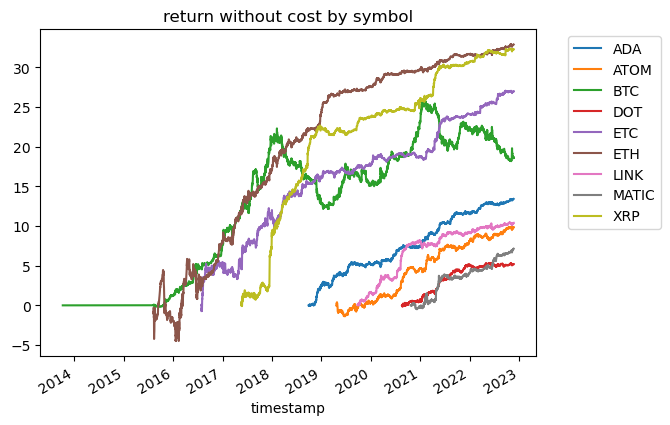

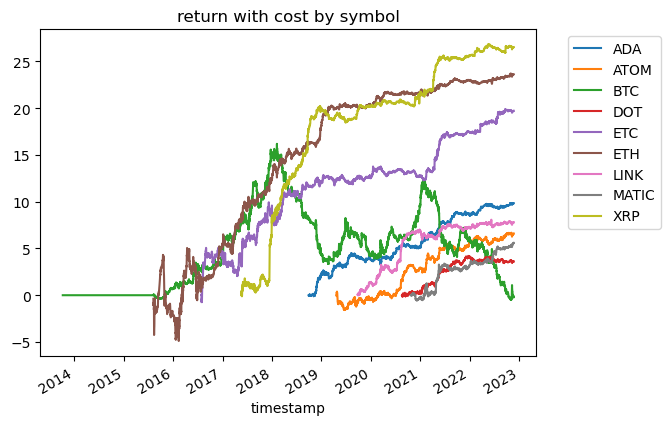

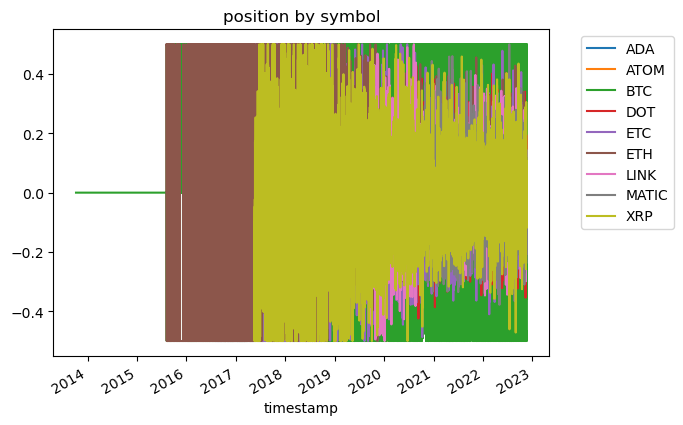

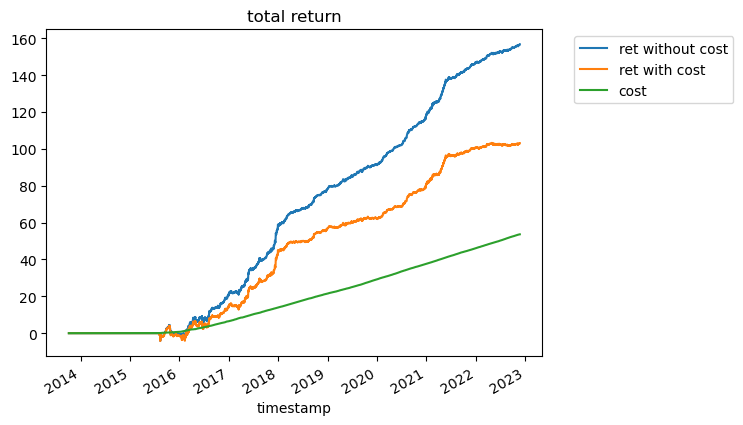

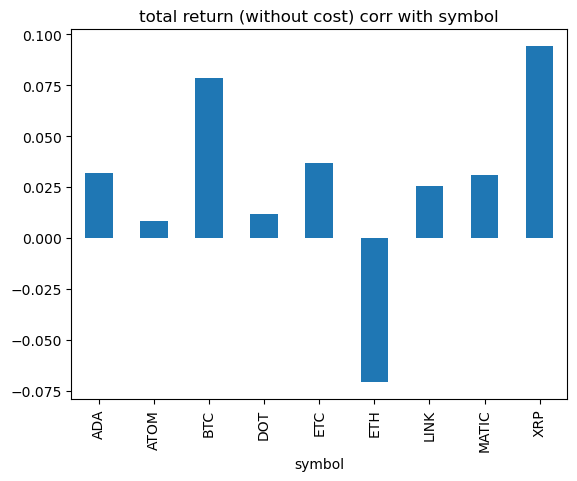

return without cost statistics
mean 0.002259058699561235
std 0.011849847627899224
sharpe 0.19064031627229686
double sharpe 1.3945183333959246
max drawdown 1.855428416275096
min -0.08835727949666491
min sharpe 0.02556731841937827
return with cost statistics
mean 0.0013670423834010836
std 0.011836755603195545
sharpe 0.11549130768840289
double sharpe 0.7586748207150704
max drawdown 2.4602541129289084
min -0.08859701504806401
min sharpe 0.015429892109338685


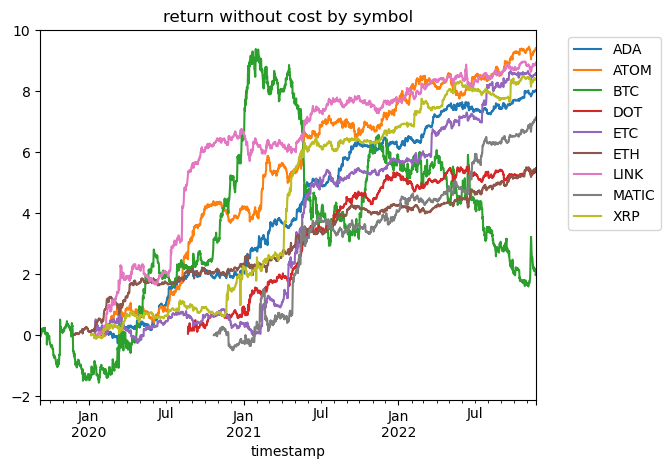

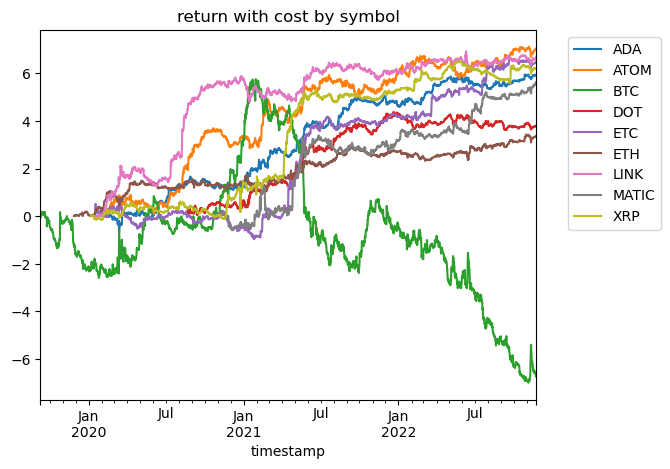

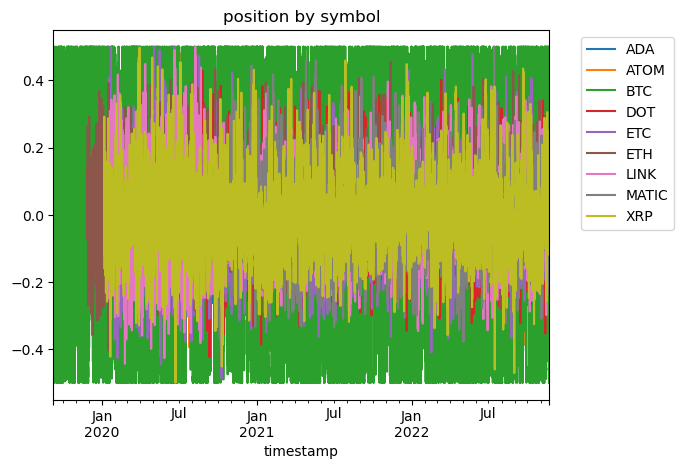

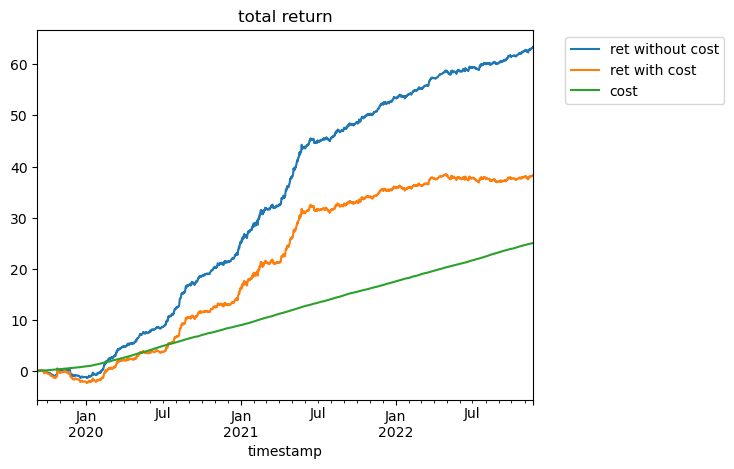

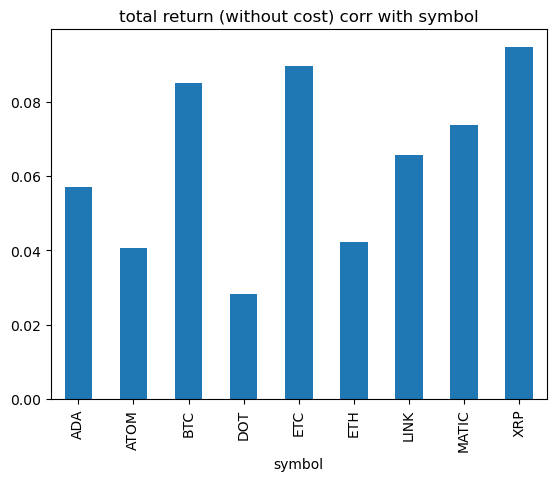

/tmp/ipykernel_12/816363772.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/816363772.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


fit df.shape (294354, 833)


/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_features)(self.estimator, remove_count, X)
/tmp/ipykernel_12/692775592.py:23: UserWarning: Persisting input arguments took 1.59s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  self.selected_features_ = mem.cache(nfr_calc_f

In [6]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-12 - 1) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank()

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna(), horizon=12)
visualize_result(df_cv.loc[~df['extended']].dropna(), horizon=12)

# fit and save model as portable format
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20221104_btc_one_h12/20221108_224508.ipynb](20221104_btc_one_h12/20221108_224508.ipynb) without hedge
- [20221104_btc_one_h12/20221108_224536.ipynb](20221104_btc_one_h12/20221108_224536.ipynb) with hedge
- [20221104_btc_one_h12/20221109_005418.ipynb](20221104_btc_one_h12/20221109_005418.ipynb) with hedge, lgbm 100 * bagging 100, subsample 0.5
- [20221104_btc_one_h12/20221109_112941.ipynb](20221104_btc_one_h12/20221109_112941.ipynb) with hedge, subsample 0.5
- [20221104_btc_one_h12/20221109_113019.ipynb](20221104_btc_one_h12/20221109_113019.ipynb) with hedge, subsample 0.5, l2 1e1
- [20221104_btc_one_h12/20221109_113046.ipynb](20221104_btc_one_h12/20221109_113046.ipynb) with hedge l2 1e1
- these are evaluated with horizon 4 (wrong setting)
- the latest version is evaluated with horizon 12
- current: with hedge, subsample 0.5 <- new baseline

- [20221104_btc_one_h12/20221110_013653.ipynb](20221104_btc_one_h12/20221110_013653.ipynb) new baseline <- good
- [20221104_btc_one_h12/20221109_215052.ipynb](20221104_btc_one_h12/20221109_215052.ipynb) y shrink
- [20221104_btc_one_h12/20221109_221350.ipynb](20221104_btc_one_h12/20221109_221350.ipynb) y^0.5, y^0.5
- [20221104_btc_one_h12/20221109_220049.ipynb](20221104_btc_one_h12/20221109_220049.ipynb) 1/y, y^2
- [20221104_btc_one_h12/20221109_220641.ipynb](20221104_btc_one_h12/20221109_220641.ipynb) 1/y^2, y^3
- [20221104_btc_one_h12/20221110_013729.ipynb](20221104_btc_one_h12/20221110_013729.ipynb) y timestamp normalized
- [20221104_btc_one_h12/20221110_014924.ipynb](20221104_btc_one_h12/20221110_014924.ipynb) y timestamp normalized, y raw

expt2

- [20221104_btc_one_h12/20221122_162656.ipynb](20221104_btc_one_h12/20221122_162656.ipynb) (evaluated with horizon 24)
- 

/tmp/ipykernel_12/816363772.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/816363772.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0


timestamp                  symbol
2022-09-24 03:00:00+00:00  ADA       0.056986
                           ATOM      0.055968
                           BTC      -0.500000
                           DOT       0.045535
                           ETC       0.066264
                                       ...   
2022-11-23 03:00:00+00:00  DOT      -0.107234
                           ETH      -0.126170
                           LINK     -0.019212
                           MATIC    -0.077983
                           XRP      -0.041444
Name: position, Length: 12968, dtype: float64
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'MATIC', 'XRP']
test shift predict


/tmp/ipykernel_12/816363772.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
/tmp/ipykernel_12/816363772.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = 1.0
/tmp/ipykernel_12/816363772.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame

position1  position2  position3
timestamp                 symbol                                 
2022-09-24 04:00:00+00:00 ADA      0.150199   0.150199   0.064584
                          ATOM     0.134395   0.134395   0.071069
                          BTC     -0.469925  -0.469925  -0.500000
                          DOT      0.006539   0.006539   0.071693
                          ETC     -0.024229  -0.024229   0.060090
...                                     ...        ...        ...
2022-11-23 02:00:00+00:00 ETC     -0.090414  -0.090414  -0.090407
                          ETH     -0.105341  -0.105341  -0.105882
                          LINK    -0.002789  -0.002789  -0.002963
                          MATIC   -0.069379  -0.069379  -0.069716
                          XRP      0.005421   0.005421   0.005474

[12951 rows x 3 columns]

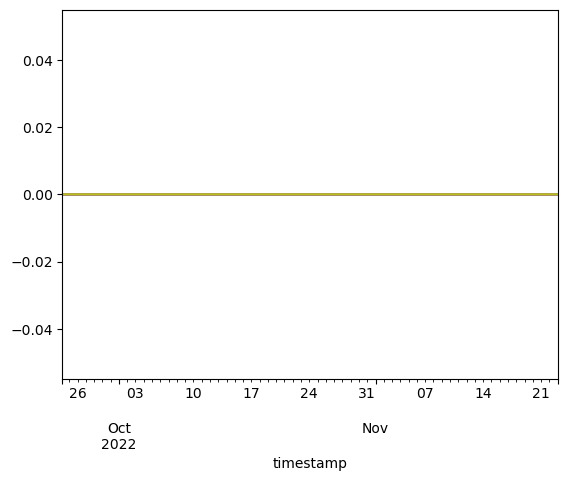

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


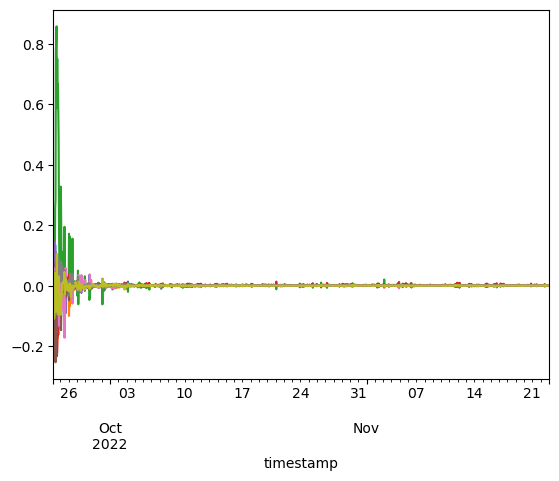

In [7]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()